 # Build a Reddit Post Classification Model
 For simplicity, this script performs a binary classification on 'science' subreddit posts

 Goal: Build a classification model that predicts reddit posts' topics (e.g., Biology or Environment) based on their title content

In [1]:
# Import other packages
# Data
import pandas as pd
import numpy as np
# import datetime as dt
from collections import Counter

# SQL
import psycopg2

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import spacy
# from spacy.lang.en import English

# Scikit-learn
from sklearn.model_selection import train_test_split

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve

 ## 1. Extract Data From PostgreSQL Database
 Reddit posts were searched and stored in the database in the script reddit_search_store.py

In [2]:
# Establish the connection
try:
    conn = psycopg2.connect(
        user='postgres', password='', host='localhost', port= '5432'
    ) # database='postgres', 
    print("Postgres server is connected")
    
    conn.autocommit = True
    cursor = conn.cursor() # Create a cursor object using the cursor() method
  
except psycopg2.OperationalError:
    print("Postgres server is not running.")
    raise

# Check for the reddit database
dbname = 'reddit'
cursor.execute("SELECT datname FROM pg_database;")
list_database = cursor.fetchall()
assert (dbname,) in list_database, dbname+" database does not exist. Need to create it!"

# Close the current connection
if conn:
    conn.close()
    cursor.close()
# Connect to the reddit database    
conn = psycopg2.connect(
    database='reddit', user='postgres', password='', host='localhost', port= '5432'
)
print("Connect to the reddit database")
conn.autocommit = True
cursor = conn.cursor()

# Check for reddit_search table
tblname = 'reddit_search'
sql_show_table = '''
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE (table_schema = 'public');
    '''
cursor.execute(sql_show_table)
list_tables = cursor.fetchall()
assert ('public', tblname) in list_tables, tblname+" TABLE does not exist. Need to create it!" 

# Extract data from the table and store it as a pandas dataframe
try:
    # Extract column names and data types of the table
    sql_colnametypes = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '"\
        + tblname + "' ORDER BY ordinal_position;"
    cursor.execute(sql_colnametypes)
    colnametypes = cursor.fetchall()
    df_colnametypes = pd.DataFrame(colnametypes, columns=['name','datatype'])
    
    # Extract data
    name_subreddit = 'science'
    flair_tag1 = 'Biology'
    flair_tag2 = 'Environment'
    sql_select = "SELECT * FROM " + tblname + " WHERE subreddit = '" + name_subreddit +\
        "' AND (link_flair_text = '" + flair_tag1 + "' OR link_flair_text = '" + flair_tag2 + "');"
    cursor.execute(sql_select)
    posts_raw = cursor.fetchall()
    df_posts_raw = pd.DataFrame(posts_raw, columns=df_colnametypes['name'].tolist())
    print("Reddit post search results have been extracted from the table.")
    
except (Exception, psycopg2.Error) as error:
    print("Error: ", error)
    conn.close()
    cursor.close()
    raise 

conn.close()
cursor.close()
print("reddit database is closed and disconnected.")

Postgres server is connected
Connect to the reddit database
Reddit post search results have been extracted from the table.
reddit database is closed and disconnected.


 ## 2. Overview of the Posts

In [3]:
df_posts_raw.head()

,id,author,title,selftext,score,url,num_comments,subreddit,created_utc,link_flair_text,link_flair_type,created_time,updated_time
0,ujvpgv,Additional-Two-7312,New study finds boosting against COVID-19 in a...,None,1,https://www.science.org/doi/10.1126/sciimmunol...,1,science,1651866680,Biology,text,2022-05-06 19:51:20,2022-05-06 16:26:15.895134
1,ujtprr,Additional-Two-7312,Staggering declines in bird populations are ta...,None,1,https://www.sciencedaily.com/releases/2022/05/...,1,science,1651861101,Environment,text,2022-05-06 18:18:21,2022-05-06 16:26:15.895134
2,ujyt2p,Additional-Two-7312,Emissions tied to the international trade of a...,None,1,https://news.uci.edu/2022/05/06/emissions-tied...,1,science,1651875342,Environment,text,2022-05-06 22:15:42,2022-05-06 20:57:31.485441
3,ujy6lb,westphall,Faecal transplants reverse hallmarks of ageing,None,1,https://www.uea.ac.uk/news/-/article/faecal-tr...,1,science,1651873561,Biology,text,2022-05-06 21:46:01,2022-05-06 20:57:31.485441
4,ujtpft,Undlarakharbioweapon,Can anyone identify this organism?,None,1,https://rumble.com/v13rfvx-ugh.html,1,science,1651861077,Biology,text,2022-05-06 18:17:57,2022-05-06 20:57:31.485441


In [4]:
df_posts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               884 non-null    object        
 1   author           884 non-null    object        
 2   title            884 non-null    object        
 3   selftext         9 non-null      object        
 4   score            884 non-null    int64         
 5   url              884 non-null    object        
 6   num_comments     884 non-null    int64         
 7   subreddit        884 non-null    object        
 8   created_utc      884 non-null    int64         
 9   link_flair_text  884 non-null    object        
 10  link_flair_type  884 non-null    object        
 11  created_time     884 non-null    datetime64[ns]
 12  updated_time     884 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 89.9+ KB


In [5]:
print("Unique flair tags:", df_posts_raw['link_flair_text'].unique())

Unique flair tags: ['Biology' 'Environment']


In [6]:
# # Remove posts with 'Retraction' tag
# if 'Retraction' in df_posts_raw['link_flair_text'].unique():
#     idx_rm = df_posts_raw['link_flair_text']=='Retraction'
#     df_posts_raw = df_posts_raw.loc[~idx_rm]

# # Replace the tags of the posts without any tag with 'Tag Missing'
# if None in df_posts_raw['link_flair_text'].unique():
#     df_posts_raw.loc[df_posts_raw['link_flair_text'].isnull(), 'link_flair_text'] = 'Tag Missing'

# print(df_posts_raw['link_flair_text'].unique())

In [7]:
# Number of unique authors
nuniq_authors = len(df_posts_raw['author'].unique())
print("Number of unique authors: {}".format(nuniq_authors))

# Check whether there are duplicate posts with the same title
_df = df_posts_raw.drop_duplicates(subset=['title'])
if _df.shape[0] < df_posts_raw.shape[0]:
    print("There are {} duplicate posts with identical title".format(df_posts_raw.shape[0]-_df.shape[0]))
del _df

# Check whether there are duplicate posts with the same URL
_df = df_posts_raw.drop_duplicates(subset=['url'])
if _df.shape[0] < df_posts_raw.shape[0]:
    print("There are {} duplicate posts with identical URL".format(df_posts_raw.shape[0]-_df.shape[0]))
del _df

Number of unique authors: 384
There are 22 duplicate posts with identical title
There are 74 duplicate posts with identical URL


 ### 2.1 Remove duplicate posts

In [8]:
# Remove duplicate posts
_df = df_posts_raw.drop_duplicates(subset=['title'])
df_posts = _df.drop_duplicates(subset=['url']).reset_index(drop=True)
del _df
print("Number of posts with unique title and URL: {}".format(df_posts.shape[0]))

Number of posts with unique title and URL: 801


 ### 2.2 Descriptive statistics of the unique posts

In [9]:
sns.set_style('ticks')
sns.set_context('talk')

Figure of the number/proportion of posts in each flair tag


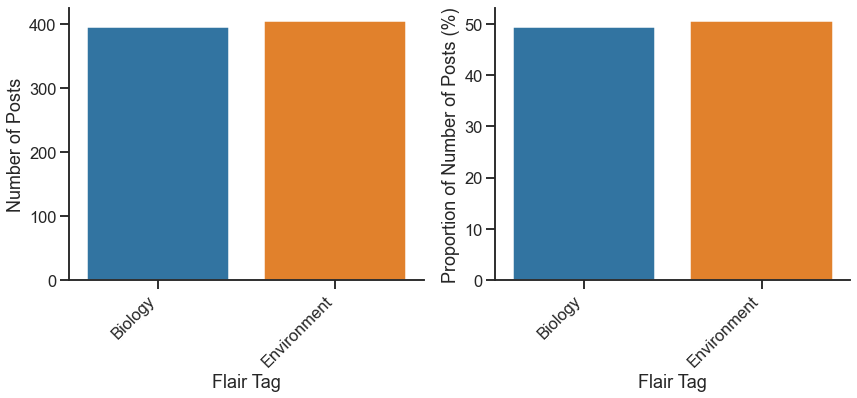

In [11]:
# Visualize the number of posts and proportion for each flair tag
list_tags = list(np.sort(df_posts['link_flair_text'].unique()))

print("Figure of the number/proportion of posts in each flair tag")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5)) # sharex=True

# Number of posts
sns.countplot(
    ax=ax1, data=df_posts,
    x='link_flair_text', order=list_tags
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_xlabel("Flair Tag")
ax1.set_ylabel("Number of Posts")
# ax1.set_title("Number of Posts for Each Flair Tag")
# Proportion of number of posts
prop_numposts = (df_posts.groupby('link_flair_text').size() / df_posts.shape[0]) * 100
sns.barplot(ax=ax2, x=prop_numposts.index, y=prop_numposts.values)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
ax2.set_xlabel("Flair Tag")
ax2.set_ylabel("Proportion of Number of Posts (%)")

sns.despine()
plt.show()

Figure of the number of comments of the posts with each flair tag


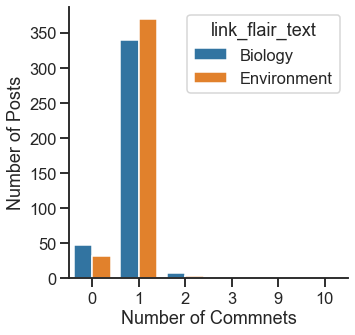

In [12]:
# Group the posts based on their number of comments
counts_numcomm = df_posts.groupby('num_comments').size()
counts_numcomm = counts_numcomm.rename('nPosts').reset_index()
# print(counts_numcomm)

# print("Figure of the number of comments of these posts")
# fig, ax = plt.subplots(figsize=(5,5))
# ax = sns.barplot(data=counts_numcomm, x='num_comments', y='nPosts')
# ax.set_xlabel("Number of Commnets")
# ax.set_ylabel("Number of Posts")
# sns.despine()
# plt.show()

# Number of comments for each flair tag
counts_numcomm_tags = df_posts.groupby(['num_comments','link_flair_text']).size().rename('nPosts')
counts_numcomm_tags = counts_numcomm_tags.reset_index()
counts_numcomm_tags_wide = counts_numcomm_tags.pivot_table(
    index='num_comments', columns='link_flair_text', values='nPosts'
)
counts_numcomm_tags_wide = counts_numcomm_tags_wide.reset_index().fillna(0)
counts_numcomm_tags = counts_numcomm_tags_wide.melt(
    id_vars='num_comments', value_vars=[flair_tag1, flair_tag2],
    value_name='nPosts'
)

print("Figure of the number of comments of the posts with each flair tag")
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(data=counts_numcomm_tags, x='num_comments', y='nPosts', hue='link_flair_text')
ax.set_xlabel("Number of Commnets")
ax.set_ylabel("Number of Posts")
sns.despine()
plt.show()

In [13]:
# Number of words in each post's title
n_words = df_posts['title'].apply(lambda x: len(x.split()))
df_nWords = df_posts[['id','link_flair_text']].join(n_words.rename('nWords'))

print("Average number of words in posts' titles (before text preprocessing):")
df_nWords.groupby('link_flair_text').agg(avg_nWords=('nWords', 'mean'))

Average number of words in posts' titles (before text preprocessing):


,avg_nWords
link_flair_text,
Biology,16.623737
Environment,22.841975


In [14]:
# Number of posts for each author
nPosts_author = df_posts.groupby(['author','link_flair_text']).size().rename('nPosts').reset_index()
print("On average, each author has {:.2f} posts (across both flair tags).".format(nPosts_author['nPosts'].mean()))

nPosts_tag1_author = nPosts_author.loc[nPosts_author['link_flair_text'] == flair_tag1] 
nPosts_tag2_author = nPosts_author.loc[nPosts_author['link_flair_text'] == flair_tag2] 
# Authors who has posted flair_tag1 and flair_tag2 posts
nPosts_both_author = nPosts_tag1_author.merge(nPosts_tag2_author, on='author', how='inner', suffixes=('_tag1','_tag2'))
idx_colrm = nPosts_both_author.columns.str.contains('link_flair_text')
nPosts_both_author = nPosts_both_author[nPosts_both_author.columns[~idx_colrm]] # not select the "link_flair_text_" columns

print(
    "{} authors have posted posts with flair tags of {} (tag1) and {} (tag2).".format(nPosts_both_author.shape[0],flair_tag1,flair_tag2)
)
print("Only show the top 5:")
nPosts_both_author.sort_values(['nPosts_tag1','nPosts_tag2'], ascending=False).head()

On average, each author has 1.93 posts (across both flair tags).
40 authors have posted posts with flair tags of Biology (tag1) and Environment (tag2).
Only show the top 5:


,author,nPosts_tag1,nPosts_tag2
0,Additional-Two-7312,21,43
10,MistWeaver80,14,46
23,a_Ninja_b0y,9,1
33,nikan69,6,4
18,TX908,5,7


 **Interim summary**

 **Descriptive summary of posts from the science subreddit search results**
 * Duplicate posts with identical titles and/or URL have been removed
 * There are roughly 400ish posts for each of the 2 flair tags
 * The majority of posts only has 1 comment
 * Many authors posted more than 1 post
 * Before text preprocessing, the average number of words (across posts) is higher for the Environment-tagged posts comparaed to the Biology counterpart.

 ## 3. Binary Classification of The Reddit Post Topic (Flair Tag)
 Predict whether a post's topic (flair tag) is "Biology" or "Environment" based on the post content ("title")
 1. Preprocess text input (using SpaCy)
 2. Visualize TF-IDF features of the preprocessed text
 3. Split data into training and testing sets
 4. Train a classification model
 5. Apply the classification model to the testing set

 ### 3.1 Preprocessing text input
 * Tokenization
 * Lemmatization
 * Removing non-alphabetic and stop words

In [15]:
# Preprocessing text (using spacy)
# Tokenization, lemmatization, removing non-alphabetic word, removing English stop words
# SpaCy's pipeline packages must be downloaded first (e.g., in Terminal, type python -m spacy download en_core_web_sm)
# For efficiency, one can use the small model ('en_core_web_sm'), but it does't ship with word vectors 
# If word vectors are required, one can use the medium ('en_core_web_md') or large 'en_core_web_lg' model
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# lemmas_title = [] # list of lemmas of each post's title
preprocs_title = [] # list of each post's title after lemmatization (a single sentence as a string)
for doc in nlp.pipe(df_posts['title'].tolist()):
    lemmas = [
        token.lemma_ for token in doc
        if token.lemma_.isalpha() and token.lemma_ not in stopwords
        ] 
    # lemmas_title.append(lemmas)
    preprocs_title.append(" ".join(lemmas))

# Combine the preprocessed title with relevant post information from the dataframe
df_posts_preprocs = df_posts[['id','author','title','link_flair_text']]
df_posts_preprocs = df_posts_preprocs.assign(preprocs_title=preprocs_title)
df_posts_preprocs.head()

,id,author,title,link_flair_text,preprocs_title
0,ujvpgv,Additional-Two-7312,New study finds boosting against COVID-19 in a...,Biology,new study find boost local location buff vacci...
1,ujtprr,Additional-Two-7312,Staggering declines in bird populations are ta...,Environment,staggering decline bird population place world...
2,ujyt2p,Additional-Two-7312,Emissions tied to the international trade of a...,Environment,emission tie international trade agricultural ...
3,ujy6lb,westphall,Faecal transplants reverse hallmarks of ageing,Biology,faecal transplant reverse hallmark age
4,ujtpft,Undlarakharbioweapon,Can anyone identify this organism?,Biology,Can identify organism


In [16]:
# Number of words in each post's title (after preprocessing)
n_words_preprocs = df_posts_preprocs['preprocs_title'].apply(lambda x: len(x.split()))
df_nWords_preprocs = df_posts_preprocs[['id','link_flair_text']].join(n_words_preprocs.rename('nWords'))

print("Average number of words in posts' titles (after text preprocessing):")
df_nWords_preprocs.groupby('link_flair_text').agg(avg_nWords=('nWords', 'mean'))

Average number of words in posts' titles (after text preprocessing):


,avg_nWords
link_flair_text,
Biology,10.436869
Environment,13.720988


 **Interim summary**

 After text preprocessing (tokenization, lemmatiaztion, stop-word removal), the average number of words are now more or less equal between the documents of the 2 topics

 ### 3.2 Visualize TF-IDF features of post titles in the entire corpus
 Project the TF-IDF features to a two-dimensional space

In [17]:
# Construct a TF-IDF matrix for the entire corpus (all posts in the extracted data)
tfidf_vect_all = TfidfVectorizer(
    lowercase=False # keep upper case sine some words may have different meangins for upper/lower cases (e.g., US vs. us)
) # stop words have been removed in the preprocessing step above 
#stop_words='english' strip_accents='unicode',
tfidf_all = tfidf_vect_all.fit_transform(
    df_posts_preprocs['preprocs_title'].to_numpy()
)

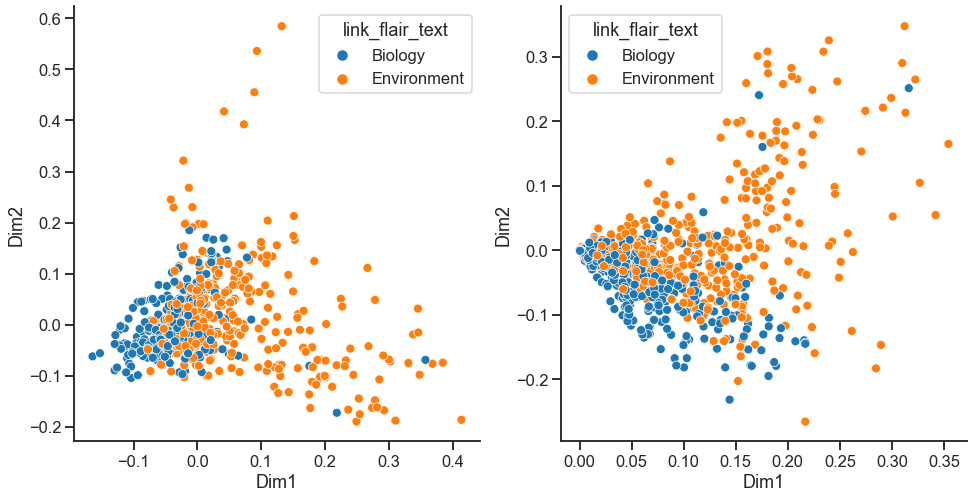

In [20]:
# Reduce the dimensions to 2D 
# Approach 1: PCA (not support sparse matrix input)
pca = PCA(n_components=2)
tfidf_all_pca2D = pca.fit_transform(np.asarray(tfidf_all.todense()))
df_pca2D = pd.DataFrame(
    tfidf_all_pca2D, index= df_posts_preprocs.index,
    columns=['Dim1','Dim2']
)
df_pca2D = df_pca2D.assign(
    id = df_posts_preprocs['id'],
    link_flair_text = df_posts_preprocs['link_flair_text']
)

# Approach 2: Truncated SVD (support sparse matrix)
# In the context of NLP, dimension reduction using SVD is also known as 
# Latent Semantic Analysis (LSA)
svd = TruncatedSVD(n_components=2)
tfidf_all_svd2D = svd.fit_transform(tfidf_all)
df_svd2D = pd.DataFrame(
    tfidf_all_svd2D, index= df_posts_preprocs.index,
    columns=['Dim1','Dim2']
)
df_svd2D = df_svd2D.assign(
    id = df_posts_preprocs['id'],
    link_flair_text = df_posts_preprocs['link_flair_text']
)

# # Approach 3: TSNE (support sparse matrix)
# tsne = TSNE(n_components=2, init='random', learning_rate='auto')
# tfidf_all_tsne2D = tsne.fit_transform(tfidf_all)
# df_tsne2D = pd.DataFrame(
#     tfidf_all_tsne2D, index= df_posts_preprocs.index,
#     columns=['Dim1','Dim2']
# )
# df_tsne2D = df_tsne2D.assign(
#     id = df_posts_preprocs['id'],
#     link_flair_text = df_posts_preprocs['link_flair_text']
# )

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
sns.scatterplot(
    ax=ax1, data=df_pca2D, x='Dim1', y='Dim2', 
    hue='link_flair_text'
)
sns.scatterplot(
    ax=ax2, data=df_svd2D, x='Dim1', y='Dim2', 
    hue='link_flair_text'
)
# sns.scatterplot(
#     ax=ax3, data=df_tsne2D, x='Dim1', y='Dim2', 
#     hue='link_flair_text'
# )
sns.despine()
plt.show()

 **Interim summary**

 It appears that documents of the 2 different topics are somewhat separated in the 2D spaces.

 Based on the results here, I expect that the classication model will be able to distinguish the two topics based on the post titles

 ### 3.3 Split training and testing data

In [21]:
# Split data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(
    df_posts_preprocs['preprocs_title'].to_numpy(), 
    df_posts_preprocs['link_flair_text'].to_numpy(), 
    test_size=0.3,
    stratify=df_posts_preprocs['link_flair_text'].to_numpy(), 
    random_state=0
)

# Number of samples
print("Number of total training samples:", X_train.shape[0])
print("Number of total testing samples:", X_test.shape[0])

# Number of samples in each class
uniq_trn, cnt_trn = np.unique(y_train, return_counts=True)
print(
    "Number of training samples with tag {} and {}, respectivly: {} and {}".format(
        uniq_trn[0], uniq_trn[1],
        cnt_trn[0], cnt_trn[1]
    )
)
uniq_tst, cnt_tst = np.unique(y_test, return_counts=True)
print(
    "Number of testing samples with tag {} and {}, respectivly: {} and {}".format(
        uniq_tst[0], uniq_tst[1],
        cnt_tst[0], cnt_tst[1]
    )
)

Number of total training samples: 560
Number of total testing samples: 241
Number of training samples with tag Biology and Environment, respectivly: 277 and 283
Number of testing samples with tag Biology and Environment, respectivly: 119 and 122


 ### 3.4 Train a classification model based on the TF-IDF features
 A Naive Bayes classifier is chosen because it has been shown to work well with natural language processing problems

In [22]:
# Custom function that runs cross_validate for a model and return the cross-validation results of the testing (validation) and training dataset
def do_cv(estimator, X, y, score_metrics, cv):
    '''
    Inputs:
        estimator - the object used to fit the data
        X - the data to be fitted 
            (could be the entire data or the training data where the testing set has been left out)
        y - the target variable (label) to be predicted
        score_metrics - the metric(s) used to evaluate the model performance
                        for a single metric: a list containing a single value (e.g., a string)
                        for multiple metrics: a list or tuple
        cv - determine the cross-validation split strategy
    Output:
        cv_res: a dataframe storing the cross-validatoin results (average and standard deviation across iterations)
    '''
    # Run cross-validation and also return the training scores
    cv_results = cross_validate(estimator, X, y,
                                scoring=score_metrics, cv=cv,
                                n_jobs=-1,
                                return_train_score=True)
    
    # Columns storing the testing (validation) and training results of the scoring metrics
    cols_test_score = ['test_'+m for m in score_metrics] # testing (validation)
    cols_train_score = ['train_'+m for m in score_metrics] # training

    # Go through each scoring metric and extract the cross-validation results
    cv_res = pd.DataFrame(columns=['valid_avg','train_avg','valid_sd','train_sd'])
    for i, (col_test, col_train) in enumerate(zip(cols_test_score, cols_train_score)):
        # Validation data set cross-validation classification performance
        metric_valid_avg = cv_results[col_test].mean()
        metric_valid_sd = cv_results[col_test].std()
        # Training (not the entire X_train) data set cross-validation classification performance
        metric_train_avg = cv_results[col_train].mean()
        metric_train_sd = cv_results[col_train].std()

        _arr = np.array([metric_valid_avg, metric_train_avg, metric_valid_sd, metric_train_sd])
        cv_res.loc[i,:] = _arr
        del _arr
        
    cv_res.index = score_metrics
    
    # Return the dataframe of the cross-validation results
    return cv_res

In [23]:
# Cross validation parameters
score_metrics = ['accuracy','roc_auc'] 
nKfold = 3
cv = StratifiedKFold(n_splits=nKfold, shuffle=True, random_state=0)

In [24]:
# Build a pipeline
# use scikit-learn TF-IDF default parameters, except for the lowercase argument
tfidf_vect = TfidfVectorizer(lowercase=False) #min_df=2, max_df=0.5, max_features=500
# keep upper case sine some words may have different meangins for upper/lower cases (e.g., US vs. us)

pipe_nb = Pipeline(
    steps=[
        ('tfidf_vect', tfidf_vect),
        ('clf', MultinomialNB())
    ]
)

# Run cross validation
print("Cross-validation results with default number of TF-IDF features")
cv_res = do_cv(pipe_nb, X_train, y_train, score_metrics, cv)
cv_res

Cross-validation results with default number of TF-IDF features


,valid_avg,train_avg,valid_sd,train_sd
accuracy,0.794673,0.991967,0.036977,0.002177
roc_auc,0.900209,0.999933,0.017983,0.000036


In [25]:
print("Default number of TF-IDF features (unique words) in the entire training corpus")
tfidf_vect = TfidfVectorizer(lowercase=False)
pipe_nb = Pipeline(
    steps=[
        ('tfidf_vect', tfidf_vect),
        ('clf', MultinomialNB())
    ]
)
# Fit the model
pipe_nb.fit(X_train, y_train)
nFeat_tfidf = len(pipe_nb['tfidf_vect'].get_feature_names_out())
print("Number of TF-IDF features: {}".format(nFeat_tfidf))
del tfidf_vect, pipe_nb

Default number of TF-IDF features (unique words) in the entire training corpus
Number of TF-IDF features: 2887


 #### 3.4.1 Reduce the number of features by adjusting TF-IDF vectorizer parameters
 Given that the number of samples (documents) in the data is much less than the number of features, there may be an overfitting issue.
 To avoid this, the number of features can be reduced by adjusting some arguments in the TF-IDF vectorizer, including
 * **max_features**: include only the top features (words) ordered by term frequency across the corpus
 * **max_df**: ignore terms that have a document frequency strictly higher than the given threshold
 * **min_df**: ignore terms that have a document frequency strictly lower than the given threshold

In [26]:
# Custom function that tunes a single parameter of the TF-IDF vectorizer using cross validation
def tfidf_nb_tuning(X, y, score_metrics, cv, **kwargs):
    if 'max_features' in kwargs:
        list_params = kwargs['max_features']
    elif 'max_df' in kwargs:
        list_params = kwargs['max_df']
    elif 'min_df' in kwargs:
        list_params = kwargs['min_df']
    else:
        print("A TFidfVectorizer parameter must be provided.")
        return 
    
    # if len(score_metric)>1:
    #     print("This function only accept a single scoring metric")
    #     return

    df_cv = pd.DataFrame()
    for param in list_params:
        if 'max_features' in kwargs:
            tfidf_vect = TfidfVectorizer(lowercase=False, max_features=param)
        elif 'max_df' in kwargs:
            tfidf_vect = TfidfVectorizer(lowercase=False, max_df=param)
        elif 'min_df' in kwargs:
            tfidf_vect = TfidfVectorizer(lowercase=False, min_df=param)
        pipe_nb = Pipeline(
            steps=[
                ('tfidf_vect', tfidf_vect),
                ('clf', MultinomialNB())
            ]
        )
        cv_res = do_cv(pipe_nb, X, y, score_metrics, cv)
        cv_res = cv_res.assign(param=param)
        df_cv = pd.concat(
            [df_cv, cv_res],
            axis=0
        )
        del tfidf_vect, pipe_nb, cv_res
        
    return df_cv

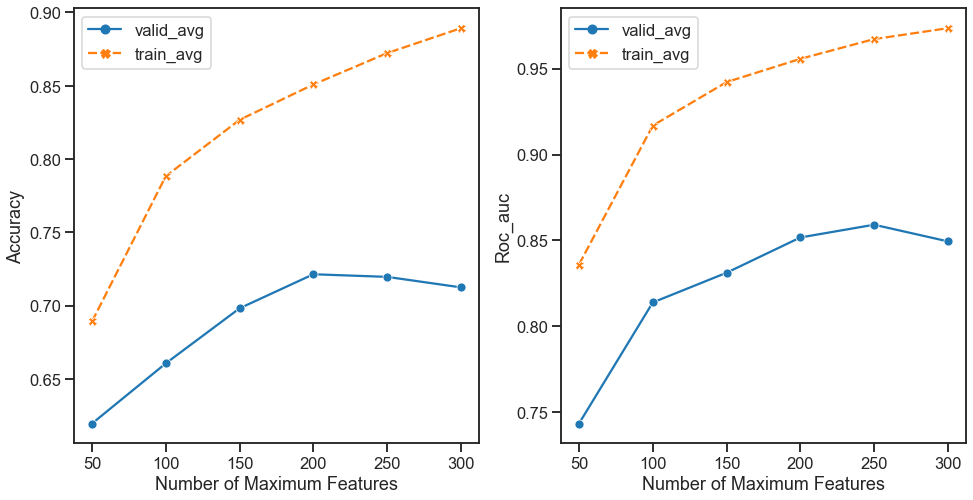

In [28]:
# Adjust the number of maximum features
# score_metrics = ['accuracy', 'roc_auc']
df_cv = tfidf_nb_tuning(
    X_train, y_train, score_metrics, cv,
    max_features=np.arange(50, 350, 50)
)
df_cv_long = df_cv.reset_index().melt(
    id_vars=['index','param'], value_vars=['valid_avg','train_avg'],
    var_name='ValTrn', value_name='score'
)
# Plot
xlabel_str = "Number of Maximum Features"
fig, axes = plt.subplots(1,2, figsize=(16,8))
for (i,ax), metric_name in zip(enumerate(axes.flatten()), score_metrics):
    sns.lineplot(
        ax=ax, 
        data=df_cv_long.loc[df_cv_long['index']==metric_name], 
        x='param', y='score',
        hue='ValTrn', style='ValTrn',
        markers=True
    )
    ax.set_xlabel(xlabel_str)
    ax.set_ylabel(metric_name.capitalize())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

del df_cv, df_cv_long, xlabel_str

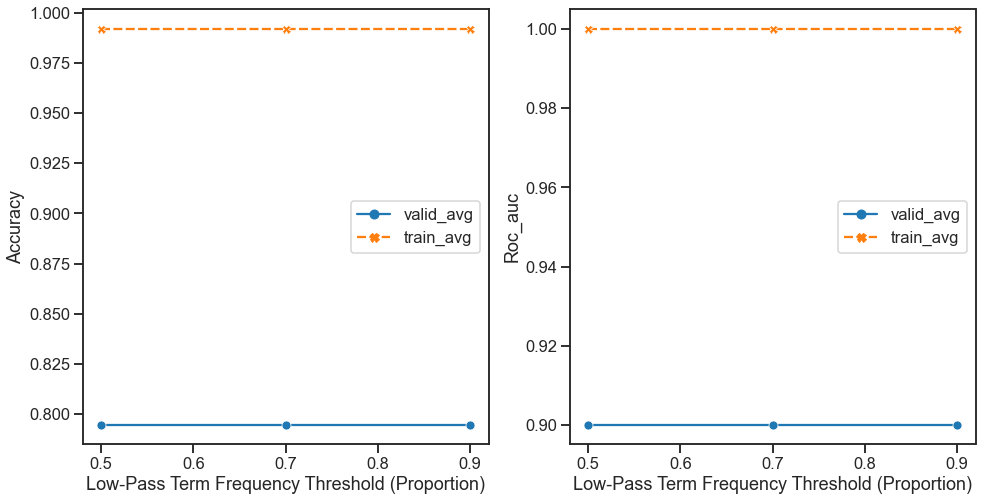

In [29]:
# Adjust the parameter max_df
# Ignore terms that have a document frequency strictly HIGHER than the given threshold
# score_metrics = ['accuracy', 'roc_auc']
df_cv = tfidf_nb_tuning(
    X_train, y_train, score_metrics, cv,
    max_df=[0.5, 0.7, 0.9]
)
df_cv_long = df_cv.reset_index().melt(
    id_vars=['index','param'], value_vars=['valid_avg','train_avg'],
    var_name='ValTrn', value_name='score'
)
# Plot
xlabel_str = "Low-Pass Term Frequency Threshold (Proportion)"
fig, axes = plt.subplots(1,2, figsize=(16,8))
for (i,ax), metric_name in zip(enumerate(axes.flatten()), score_metrics):
    sns.lineplot(
        ax=ax, 
        data=df_cv_long.loc[df_cv_long['index']==metric_name], 
        x='param', y='score',
        hue='ValTrn', style='ValTrn',
        markers=True
    )
    ax.set_xlabel(xlabel_str)
    ax.set_ylabel(metric_name.capitalize())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

del df_cv, df_cv_long, xlabel_str   

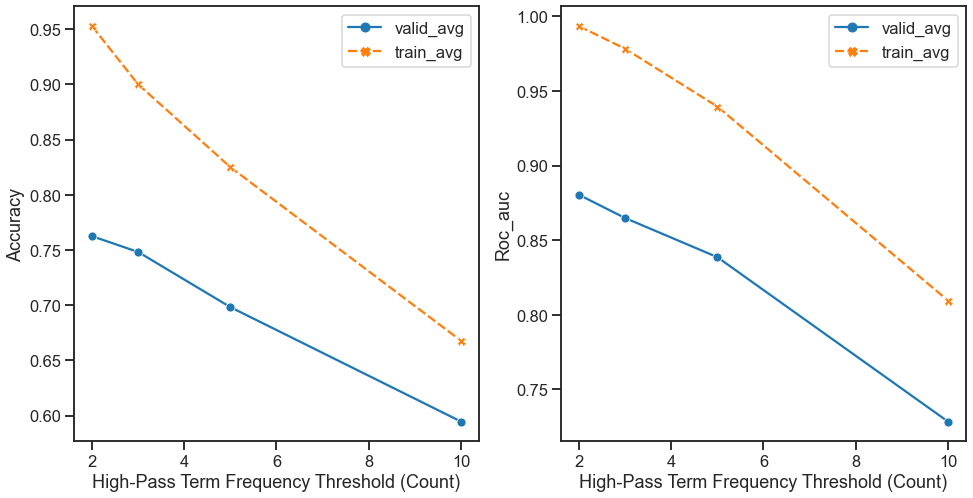

In [30]:
# Adjust the parameter min_df
# Ignore terms that have a document frequency strictly LOWER than the given threshold
# score_metrics = ['accuracy', 'roc_auc']
df_cv = tfidf_nb_tuning(
    X_train, y_train, score_metrics, cv,
    min_df=[2, 3, 5, 10]
)
df_cv_long = df_cv.reset_index().melt(
    id_vars=['index','param'], value_vars=['valid_avg','train_avg'],
    var_name='ValTrn', value_name='score'
)
# Plot
xlabel_str = "High-Pass Term Frequency Threshold (Count)"
fig, axes = plt.subplots(1,2, figsize=(16,8))
for (i,ax), metric_name in zip(enumerate(axes.flatten()), score_metrics):
    sns.lineplot(
        ax=ax, 
        data=df_cv_long.loc[df_cv_long['index']==metric_name], 
        x='param', y='score',
        hue='ValTrn', style='ValTrn',
        markers=True
    )
    ax.set_xlabel(xlabel_str)
    ax.set_ylabel(metric_name.capitalize())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

del df_cv, df_cv_long, xlabel_str 

 It appears that the model performance peaks when
 * The number of maximum features is between 200 and 300 (i.e., when the top 200~300 words with the highest frequency are included)
 * The min_df parameter is 2 (i.e., when terms/words that appear less than 2 times across posts are excluded)

 It appears that the max_df parameter does not have effect on the model performance

 Instead of tuning individual parameters separately, we can also tune these parameters simultaneously using a grid-search cross-validation

 In other words – try to find out the best combination of parameters

In [31]:
# Pipeline
tfidf_vect = TfidfVectorizer(lowercase=False)
pipe_nb = Pipeline(
    steps=[
        ('tfidf_vect', tfidf_vect),
        ('clf', MultinomialNB())
    ]
)
# Parameters grid
params = {
    'tfidf_vect__max_features': np.arange(50, 350, 50) , 
    'tfidf_vect__max_df': [0.5, 0.7, 0.9], 
    'tfidf_vect__min_df': [2, 3, 5, 10] 
}
# Run Grid search cross-validation
search_tfidf_nb = GridSearchCV(
    estimator=pipe_nb,
    param_grid=params,
    scoring='accuracy', 
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
# Fit the training data set
search_tfidf_nb.fit(X_train, y_train)

print('Best parameters:', search_tfidf_nb.best_params_) #, '\n'
print('Best score: {:.2f}'.format(search_tfidf_nb.best_score_)) #, '\n'

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'tfidf_vect__max_df': 0.5, 'tfidf_vect__max_features': 300, 'tfidf_vect__min_df': 3}
Best score: 0.73


 **Interim Summary**

 When considering all TF-IDF vectorizer parameters simultaneously, the grid search cross-validation results show that the model performs the best when
 * max_features = 300
 * min_df = 3
 * max_df = 0.5

 #### 3.4.2 Tune Naive Bayes parameters
 Further, I will tune the parameter for the Naive Bayes classifer

 Specifically, I will find the best alpha value for Laplace smoothing, which handles the problem of zero probability in Naïve Bayes theorem

 (default value = 1; 0: no smoothing; larger alpha makes the probability closer to 0.5)

In [32]:
# Further tune the parameters for the Naive Bayes classifier
# Build a pipeline using the optimized parameters for TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(
    lowercase=False,
    max_features=search_tfidf_nb.best_params_['tfidf_vect__max_features'],
    max_df=search_tfidf_nb.best_params_['tfidf_vect__max_df'],
    min_df=search_tfidf_nb.best_params_['tfidf_vect__min_df']
)
pipe_nb = Pipeline(
    steps=[
        ('tfidf_vect', tfidf_vect),
        ('clf', MultinomialNB())
    ]
)
# Parameters grid
params = {
    'clf__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]
}
# Run Grid search cross-validation
search_nb = GridSearchCV(
    estimator=pipe_nb,
    param_grid=params,
    scoring='accuracy', 
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
# Fit the training data set
search_nb.fit(X_train, y_train)

print('Best parameters:', search_nb.best_params_) #, '\n'
print('Best score: {:.2f}'.format(search_nb.best_score_)) #, '\n'

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'clf__alpha': 0.5}
Best score: 0.73


 **Interim Summary**

 The best alpha value for the Naive Bayes classifer is 0.5

 #### 3.4.3 Train the classification pipeline based on the best parameters of the TF-IDF vectorizer and the Naive Bayes classifier

In [33]:
# Build a pipeline using the optimized parameters
tfidf_vect = TfidfVectorizer(
    lowercase=False,
    max_features=search_tfidf_nb.best_params_['tfidf_vect__max_features'],
    max_df=search_tfidf_nb.best_params_['tfidf_vect__max_df'],
    min_df=search_tfidf_nb.best_params_['tfidf_vect__min_df']
)
nb_clf = MultinomialNB(
    alpha=search_nb.best_params_['clf__alpha']
)
pipe_nb = Pipeline(
    steps=[
        ('tfidf_vect', tfidf_vect),
        ('clf', nb_clf)
    ]
)

# Fit the model
pipe_nb.fit(X_train, y_train)
nFeat_tfidf = len(pipe_nb['tfidf_vect'].get_feature_names_out())
print("Number of TF-IDF features: {}".format(nFeat_tfidf))

Number of TF-IDF features: 300


 ### 3.5 Apply the classification model to the testing data set

Naive Bayes Classification Accuracy Based on TF-IDF Features: 0.82
              precision    recall  f1-score   support

     Biology       0.91      0.70      0.79       119
 Environment       0.76      0.93      0.84       122

    accuracy                           0.82       241
   macro avg       0.84      0.82      0.81       241
weighted avg       0.84      0.82      0.81       241



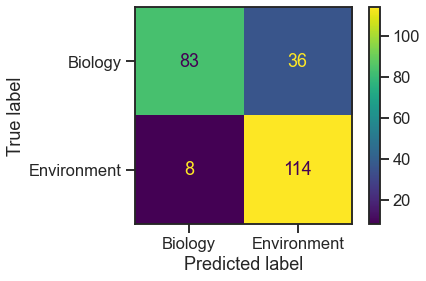

In [34]:
# Apply the model to the testing data set
y_pred_nb = pipe_nb.predict(X_test)

# Display classification report
print("Naive Bayes Classification Accuracy Based on TF-IDF Features: {:.2f}".format(
    accuracy_score(y_test, y_pred_nb)
    )
)
print(
    classification_report(y_test, y_pred_nb)
)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_nb, labels=pipe_nb['clf'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb['clf'].classes_)
disp.plot()
plt.show()

# ConfusionMatrixDisplay.from_estimator(pipe_nb, X_test, y_test)
# plt.show()

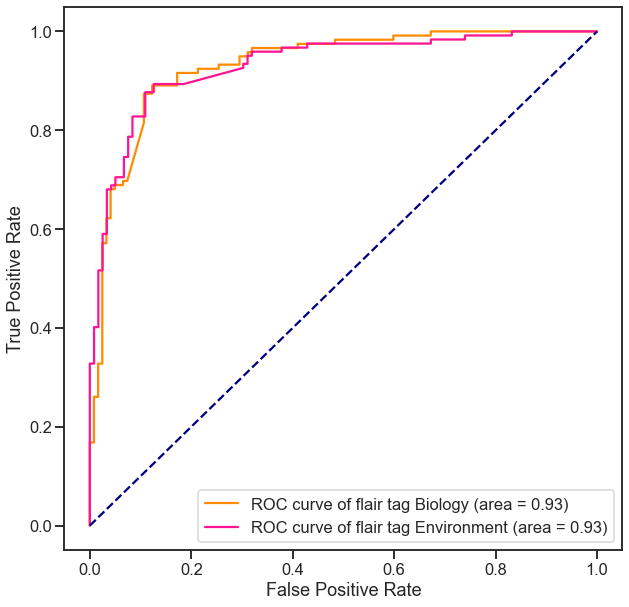

In [37]:
# Plot ROC Curve 
# Calcualte predicted probability of each class
y_pred_nb_proba = pipe_nb.predict_proba(X_test)

# Calcualte the false positive and true positive rate for each class (topic/flair tag)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, tag in enumerate(pipe_nb['clf'].classes_):
    fpr[tag], tpr[tag], thresholds = roc_curve(y_test, y_pred_nb_proba[:,i], pos_label=tag)
    roc_auc[tag] = auc(fpr[tag], tpr[tag])

# Plot the ROC Curve (and report the AUC score)
plt.figure(figsize=(10,10))
for tag, color in zip(pipe_nb['clf'].classes_, ['darkorange', 'deeppink']):
    plt.plot(
        fpr[tag], tpr[tag], color=color,
        label="ROC curve of flair tag {s} (area = {f:.2f})".format(s=tag, f=roc_auc[tag])
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

 **Summary of the classification model**

 After reducing the number of features and parameter tuning for the classifier, the classification model achieves good classification performance on predicting the topic (flair tag) of reddit posts based on their titles
 * Accuracy: 82%
 * Area under the curve (AOC): 0.93

 ## 4. Explore The Most Common Words in Posts of Each Topic (Flair Tag)
 Perform Latent Dirichlet Allocation analysis

 It is expected that the most common words in posts with the Biology and Environment flair tag will be biology- and environment-related words, respectively.

In [38]:
tfidf_vect = TfidfVectorizer(
    lowercase=False,
    max_features=search_tfidf_nb.best_params_['tfidf_vect__max_features'],
    max_df=search_tfidf_nb.best_params_['tfidf_vect__max_df'],
    min_df=search_tfidf_nb.best_params_['tfidf_vect__min_df']
)
tfidf_all = tfidf_vect.fit_transform(df_posts_preprocs['preprocs_title'].to_numpy())
feature_names = tfidf_vect.get_feature_names_out()

nTags = 2
lda = LatentDirichletAllocation(
    n_components=nTags, random_state=0
) #max_iter=10, learning_method='batch'
lda.fit(tfidf_all)

n_topwords = 5
topwords_tag = dict()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx))
    words = []
    # get the most common words for each topic
    for i in topic.argsort()[:-n_topwords - 1:-1]:
        words.append(feature_names[i])
    print(words)
    topwords_tag[topic_idx] = words

Topic 0:
['climate', 'use', 'study', 'change', 'year']
Topic 1:
['human', 'cell', 'find', 'time', 'new']


In [39]:
for topic_idx in topwords_tag.keys():
    topword = topwords_tag[topic_idx][0]
    idx = df_posts_preprocs['preprocs_title'].str.contains(topword)
    tag_name = df_posts_preprocs.loc[idx,'link_flair_text'].value_counts().index[0]
    print(
        "Topic {} is {} since the top common word {} appears more frequently in posts with this flair tag".format(
            topic_idx, tag_name, topword
        )
    )

Topic 0 is Environment since the top common word climate appears more frequently in posts with this flair tag
Topic 1 is Biology since the top common word human appears more frequently in posts with this flair tag


 Based on the top 5 most common words, it seems that Topic 0 is Environment and Topic 1 is Biology.

 This is confirmed by examining the frequency of the most common word in each topic (flair tag) category.

 **Summary**

 * The classification model successfully predicts the topic (flair tag) of a reddit post based on its title
 * The most common words in posts of each topic (flair tag) are identified, and these words match my expectation.

 **Future direction**
 * Expand the number of posts in the database (i.e., more samples)
 * Build a multiclass classification model that predit/classifiy multiple topics (flair tags) of reddit posts
 * Build the classification model using other methods, such as neural networks